# The Python Global Interpreter Lock

It is surprising to many people new to Python that threads in Python do not actually execute bytecodes within those threads in parallel.  A mechanism called the Global Interpreter Lock (GIL)—which is a kind of lock, but in the C code that Python itself is written in—speeds up internals like reference counting, and makes developing extension modules easier.

In earlier lessons we showed function bytecode, and discussed the fact that switches between threads, at the Python level, are always passing control at some point *between* individual bytecodes.  This means that threads in Python itself do not utilize multiple cores that your machine might have.

## A History Lesson

Prior to about 2005, computers with multiple CPUs—let alone with multiple cores on the same silicon—were rare.  When Python, and a great many other languages, were created, at the operating-system-level itself, concurrency only created a simulation of parallelism via *time slicing*.  This is what Python does with language-level threads.

There are other Python implementations other than CPython.  Notably, neither Jython (for the Java Virtual Machine \[JVM\]) or IronPython (for the .Net Common Language Runtime \[CLR\]) have a GIL, and both have "true" threading.  That said, neither is generally faster that CPython, and neither is well maintained in recent years.  PyPy can be dramatically faster than CPython in many cases, but it retains the GIL.

## Does It Matter?

Developers who first hear about Python's GIL, mostly those coming from other programming languages with a different model, tend to worry about the GIL making Python threading slow.  They are not *always* wrong, but mostly it makes little difference or can be worked around.

Overall, the answer is "maybe, but probably not."

* Python **itself** is not truly parallel, but Python I/O almost always runs outside of Python itself.  If you read a file on disk, or data over the network, or from a socket, you leave the Python GIL, even with the functions built into Python.  If each thread is I/O bound, a small fraction of its work is spent on Python instructions themselves.

* Extension modules written in other languages, such as for numeric computing, also release the GIL.  If your long-running thread consists of calls to large NumPy, or PyTorch, or other library, functions, little of parallelism is limited by the GIL. 

* When you really do need to write your computation in Python itself rather than extension libraries, you might consider `multiprocessing`, discussed in the next lesson.  This has its own limitations, but it turns over concurrency/parallelism to the underlying operating system.

## Configuring Time-Slicing

CPython exposes quite a lot.  For example, you can query its context-switching goal, and modify it at runtime.

In [1]:
import sys
switchtime = sys.getswitchinterval()
print(f"Threads (try to) switch every {switchtime} seconds")

Threads (try to) switch every 0.005 seconds


In [2]:
# Increase the switching frequency slightly
sys.setswitchinterval(switchtime * 0.9)
sys.getswitchinterval()

0.0045

## An I/O-Bound Task

Let's revisit the example from our first lesson and run an I/O bound task multithreaded to prove the GIL is not an issue in this case.  We saw in two previous lessons that querying multiple URLs can be **much** faster if we add threading.

In [3]:
import requests
from itertools import product

base_url = "http://localhost:5000"
exchanges = ['bitfinex', 'bitstamp', 'kraken']
dates = ['2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
         '2020-04-05', '2020-04-06']
currencies = ['btc', 'eth', 'ltc']

def check_price(exchange, date, currency):
    url = f"{base_url}/price/{exchange}/{currency}/{date}"
    return requests.get(url).json()

In [4]:
%%time
# Check 54 combinations of query params
for query in product(exchanges, dates, currencies):
    check_price(*query)
    print('•', end='', flush=True)
print()

••••••••••••••••••••••••••••••••••••••••••••••••••••••
CPU times: user 534 ms, sys: 130 ms, total: 664 ms
Wall time: 39.4 s


In [5]:
%%time
from threading import Thread

threads = []
for query in product(exchanges, dates, currencies):
    threads.append(Thread(target=check_price, args=query))
    threads[-1].start()
    
for thread in threads:
    thread.join()
    print('•', end='', flush=True)
print()

••••••••••••••••••••••••••••••••••••••••••••••••••••••
CPU times: user 332 ms, sys: 137 ms, total: 469 ms
Wall time: 1.13 s


## A CPU-Bound Task

Let us take a look at a function that is strictly about computational work.  The effect of threads will be very different here.  For the example, we will do a computation of the escape orbits of the famous Mandelbrot set.  The function is quite simple.

In [6]:
def mandelbrot(z0:complex, orbits:int) -> int:
    z = z0
    for n in range(orbits):
        if abs(z) > 2.0:
            return n
        z = z * z + z0
    return orbits

# How many iterations for sample point to "escape"?
mandelbrot(0.0965-0.638j, 255)

17

A thing to keep in mind is that if you do this sort of calculation more seriously, you will really want to use a numeric extension library like NumPy, Numba, or Cython, anyway.  Besides doing faster single threaded operations, they also release the GIL and usually do their own multi-threading of single Python calls.

For the example, we do it in pure Python, except a NumPy array is still a convenient place to store the results calculated on Python numbers, which I do.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [8]:
%%time
def draw_canvas(escape=255, x=0.1015, y=-0.633, size=0.01):
    global canvas
    xspan, yspan = canvas.shape
    for row, col in product(range(xspan), range(yspan)):
        real = x - (size/2) + (size * col/xspan)
        imag = y - (size/2) + (size * row/yspan)
        z0 = complex(real, imag)
        canvas[row, col] = mandelbrot(z0, escape)

canvas = np.empty(shape=(1600, 1600), dtype=np.uint8)
draw_canvas()
print(canvas)

[[ 17  17  17 ... 119 132 136]
 [ 17  17  17 ... 115 126 141]
 [ 17  17  17 ... 110 133 126]
 ...
 [ 19  19  19 ...  57  57  57]
 [ 19  19  19 ...  57  57  57]
 [ 19  19  19 ...  57  57  57]]
CPU times: user 18.4 s, sys: 27.5 ms, total: 18.4 s
Wall time: 18.4 s


Let's visualize the "canvas" we created.

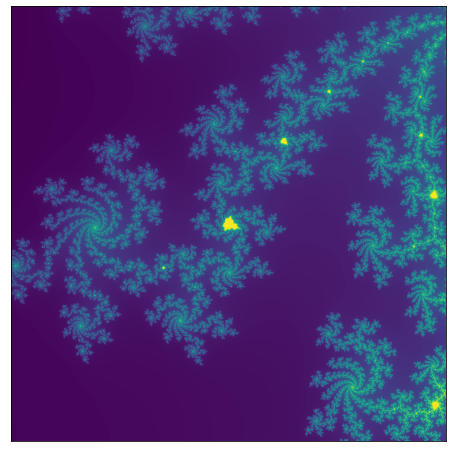

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(canvas);

This took moderately long; but notice that this is a classically *embarrassingly parallel* problem.  Every one of the pixels in the canvas is calculated with no dependency on other pixels.  We call `mandelbrot()` 1600x1600 = 2,560,000 times.  

Running 2.5M threads is clearly absurd, but perhaps there is a way to partition the work into a moderate number of threads.  For example, I have 8 cores on my computer, so dividing the canvas being rendered in a 4x4 grid would give us 16 threads.  If every thread works on a non-overlapping part of the canvas, there is no concern about race conditions or deadlocks.

In [10]:
from threading import Thread

def mandelbrot_many(zs, escape):
    """Calculate many Mandelbrot orbits
    
    zs: a dictionary mapping array coords to complex number
        e.g, {(14, 37): 0.0965-0.638j, (14, 38): ...}
    escape: the orbit at which to stop if no large value 
    
    zs is mutated to contain escape as value, e.g.:
       {(14, 37): 17, (14, 38): ...}
    """
    for pos, z0 in zs.items():
        zs[pos] = mandelbrot(z0, escape)

In [11]:
def draw_canvas_16thread(escape=255, x=0.1015, y=-0.633, size=0.01):
    pix, _ = canvas.shape
    span, threads, blocks = pix//4, [], []
    
    for xblock, yblock in product(range(0, pix, span), range(0, pix, span)):
            zs = dict(); blocks.append(zs)
            for row, col in product(range(xblock, xblock+span), 
                                    range(yblock, yblock+span)):
                real = x - (size/2) + (size * col/pix)
                imag = y - (size/2) + (size * row/pix)
                zs[(row, col)] = complex(real, imag)
                
            t = Thread(target=mandelbrot_many, args=(zs, escape), 
                       name=f"Thread-{xblock}x{yblock}")
            t.start()
            threads.append(t)
            
    # Wait on all the threads
    for t in threads:
        print(f"Joining {t.name}")
        t.join()
        
    # Populate the canvas
    for zs in blocks:
        for pos, orbit in zs.items():
            canvas[pos] = orbit

In [12]:
%%time
canvas = np.empty(shape=(1600, 1600), dtype=np.uint8)

# Validate the canvas
xspan, yspan = canvas.shape
assert xspan == yspan
assert xspan % 4 == 0

draw_canvas_16thread()

Joining Thread-0x0
Joining Thread-0x400
Joining Thread-0x800
Joining Thread-0x1200
Joining Thread-400x0
Joining Thread-400x400
Joining Thread-400x800
Joining Thread-400x1200
Joining Thread-800x0
Joining Thread-800x400
Joining Thread-800x800
Joining Thread-800x1200
Joining Thread-1200x0
Joining Thread-1200x400
Joining Thread-1200x800
Joining Thread-1200x1200
CPU times: user 19.5 s, sys: 595 ms, total: 20.1 s
Wall time: 19.1 s


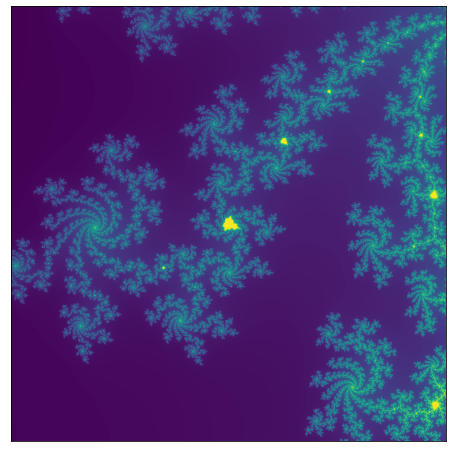

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.imshow(canvas);

## Summary

In this lesson we learned about one of the most "hated" features of Python: the GIL. Every post you read that is titled "why not Python?" or "Python vs \[insert language\]" will mention the GIL as a major drawback.

In our next lesson we'll learn how we can improve our code if it's CPU bound.